# Spooky Author Identification

In [1]:
#Kernel: base(Python 3.12.2)
#%pip install cmake
#%pip install xgboost --no-binary xgboost -v
#%pip install textstat
#%pip install statsmodels
#%pip install torch
#%pip install xgboost
#%pip install numpy==1.26.4  #due to some package not compatible with numpy>2.0.0
#%pip install --upgrade pip
#%pip install --upgrade jupyter ipywidgets
#%pip install lightgbm
#%pip install catboost

In [ ]:
# Load Important packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and EDA 
import re
import spacy
import textstat
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Word Embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
import torch

# Modeling
import sklearn
from sklearn.model_selection import train_test_split
from itertools import permutations
from sklearn.decomposition import LatentDirichletAllocation, NMF, PCA 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.inspection import permutation_importance

# Solve XGBoost crashed problem
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


2025-01-16 08:16:42.189746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [246]:
# Load the data 
raw_train = pd.read_csv('train.csv')
raw_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [257]:
# Take a look at the data
pd.set_option('display.max_colwidth', 60)
print(raw_train.info())
print(raw_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      19579 non-null  object
 1   text    19579 non-null  object
 2   author  19579 non-null  object
dtypes: object(3)
memory usage: 459.0+ KB
None
        id                                                         text author
0  id26305  This process, however, afforded me no means of ascertain...    EAP
1  id17569  It never once occurred to me that the fumbling might be ...    HPL
2  id11008  In his left hand was a gold snuff box, from which, as he...    EAP
3  id27763  How lovely is spring As we looked from Windsor Terrace o...    MWS
4  id12958  Finding nothing else, not even gold, the Superintendent ...    HPL


### Exploratory Data Analysis (EDA)

I will perform exploratory data analysis, which includes **inspecting, cleaning, and visualizing** the data, followed by **preparing the text data for modeling**.

In [5]:
# Make a copy of raw_train and raw_test dataset
clean_train = raw_train.copy()
clean_test = raw_test.copy()

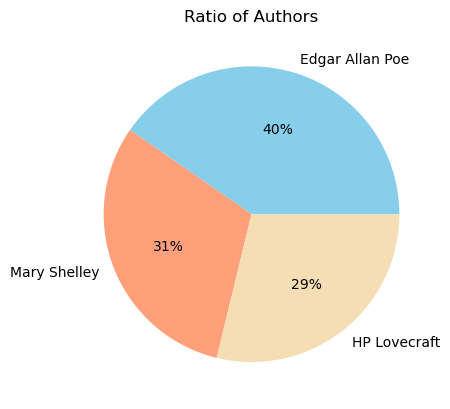

In [6]:
# Check the ratio of the text from different authors (The target labels)
labels = clean_train.author.replace(['EAP', 'MWS', 'HPL'], ['Edgar Allan Poe', 'Mary Shelley', 'HP Lovecraft']).value_counts().index
values = clean_train.author.replace(['EAP', 'MWS', 'HPL'], ['Edgar Allan Poe', 'Mary Shelley', 'HP Lovecraft']).value_counts().values

plt.pie(values, labels = labels, colors = ['skyblue', 'lightsalmon', 'wheat'], autopct = '%1.0f%%')
plt.title('Ratio of Authors');

The dataset is roughly balanced, with about 10% more texts written by Edgar Allan Poe compared to the other two authors.  

The data type of the target variable 'author' is object, which may pose a challenge for calculating model performance later. I will create a new column, 'author_encoded', using the integers 0, 1, and 2 to represent the authors.

In [7]:
# Create a new column of 'anthor_encoded'
author_mapping = {'EAP': 0, 'MWS': 1, 'HPL': 2}
clean_train['author_encoded'] = clean_train['author'].map(author_mapping)

In [8]:
# Check if there is duplicated rows
print('There are ', clean_train.duplicated(subset = ['text']).sum(), 'duplicated rows.')

There are  0 duplicated rows.


In [ ]:
# Take a look at the text from each author
pd.set_option('display.max_colwidth', 120)
for category, group in clean_train.groupby('author'):
    print(category)
    print(group['text'].str.ljust(120).sample(5))
    print()

EAP
10960    A figure, dressed like a magician, appears seated at the bottom of a wall, holding a wand in one hand, and a book in...
1594     Cast by that ruffian, Gruff, who made me a present of five dollars.                                                 ...
6081     I finally concluded that my senses were impressed by a certain air of gravity, sadness, or, still more properly, of ...
10626    Surely, man had never before so terribly altered, in so brief a period, as had Roderick Usher It was with difficulty...
11847    They would appear to be walking, with heels up and head down, in the manner of flies on a ceiling.                  ...
Name: text, dtype: object

HPL
17281    In his boyhood he had revelled through long visits there, and had found weird marvels in the woods beyond the orchar...
2439     He must have been trapped by the sinking whilst within his black abyss, or else the world would by now be screaming ...
1675     Barzai knew so much of the gods that he could tell of

In [15]:
# Check if there are digits in the text
print('There are ', len(clean_train[clean_train['text'].str.contains(r'\d+')]), 'text contains digit.')

There are  0 text contains digit.


The text data looks relatively clean and doesn't require much additional cleaning beyond tokenization, lemmatization, and removing stop words, punctuation,  and short words—all of which can be handled by the spaCy package.
  
  
##### Feature Engineering  
    
I will explore the linguistic features which reflect the writing style of different authors through the following perspectives:    

1. **Flesch Reading Ease score**: a score that measures how easy a text is to read. The higher the score, the easier it is to understand the document.

2. **Gunning Fog Index**: a readability test for English writing. The index estimates the years of formal education a person needs to understand the text on the first reading.

3. **Sentence Length**: the average length of sentences in a text.

4. **Word Length**: the average length of words used by the authors.

5. **POS Tags Distribution**: frequencies of part-of-speech (POS) tags like nouns, verbs, adjectives, and adverbs.
  
6. **Usage of Function Words**: the ratio of function words to the total number of words.  
  
7. **Type-Token Ratio**: the ratio of unique words (types) to the total number of words (tokens) in a text.  
  
8. **Word Frequency**: the frequency of words used by the authors.  

In [ ]:
# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Define the function POS tags for function words
function_pos = {"DET", "PRON", "ADP", "CONJ", "AUX", "CCONJ", "SCONJ", "PART", "INTJ"}

# Define a function to extract features reflecting writing styles
def linguistic_features(text):
    # Flesch Reading Ease score
    flesch_reading_ease = textstat.flesch_reading_ease(text)

    # Gunning For Index
    gunning_fog_index = textstat.gunning_fog(text)

    # Creating a Doc container using spaCy package
    text = text.lower()
    doc = nlp(text)

    # Sentence length
    sentence_length = [len(sent) for sent in doc.sents]
    sentence_length_avg = np.mean(sentence_length) if sentence_length else 0

    # Word length
    word_length = [len(token.text) for token in doc if token.is_alpha]
    word_length_avg = np.mean(word_length) if word_length else 0

     # Tokenize and count total words
    tokens = [token.text for token in doc if token.is_alpha]
    total_words = len(tokens)
    

    # Count nouns, verbs, adj, adv, function words, and unique words
    count_nouns = len([token.text for token in doc if token.pos_ == 'NOUN'])
    count_verbs = len([token.text for token in doc if token.pos_ == 'VERB'])
    count_adj = len([token.text for token in doc if token.pos_ == 'ADJ'])
    count_adv = len([token.text for token in doc if token.pos_ == 'ADV'])
    count_function_words = len([token.text for token in doc if (token.is_alpha and token.pos_ in function_pos)])
    count_unique_words = len(set(tokens))

    # Calculate ratios
    nouns_ratio =  count_nouns / total_words if total_words > 0 else 0
    verbs_ratio =  count_verbs / total_words if total_words > 0 else 0
    adj_ratio =  count_adj / total_words if total_words > 0 else 0
    adv_ratio =  count_adv / total_words if total_words > 0 else 0
    function_words_ratio = count_function_words / total_words if total_words > 0 else 0
    type_token_ratio = count_unique_words / total_words if total_words > 0 else 0

    # Clean text (lemmatized, no stop words, punctuation, and short words)
    cleaned_text = ' '.join([token.lemma_ for token in doc 
                             if not (token.is_stop or token.is_punct) and len(token) > 2])

    return flesch_reading_ease, gunning_fog_index, sentence_length_avg, word_length_avg, nouns_ratio, verbs_ratio, adj_ratio, adv_ratio, function_words_ratio, type_token_ratio, cleaned_text


In [17]:
# Extract linguistic features and clean text of text data in training set
lingu_feature_train = clean_train['text'].apply(linguistic_features).apply(pd.Series)
lingu_feature_train.columns = ['flesch_reading', 'gunning_fog', 'sent_len', 'word_len', 'noun_freq', 
                               'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token', 'cleaned_text']

clean_train = pd.concat([clean_train, lingu_feature_train], axis = 1)

In [18]:
# Extract linguistic features and clean text of text data in test set
lingu_feature_test = clean_test['text'].apply(linguistic_features).apply(pd.Series)
lingu_feature_test.columns = ['flesch_reading', 'gunning_fog', 'sent_len', 'word_len', 'noun_freq', 
                               'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token', 'cleaned_text']

clean_test = pd.concat([clean_test, lingu_feature_test], axis = 1)

In [19]:
clean_train.describe()

,author_encoded,flesch_reading,gunning_fog,sent_len,word_len,noun_freq,verb_freq,adj_freq,adv_freq,funct_word,type_token
count,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000,19579.000000
mean,0.884315,62.962014,13.645830,29.759885,4.466894,0.203321,0.126852,0.080366,0.057910,0.507038,0.889258
std,0.823379,25.084772,7.954924,18.789673,0.580367,0.078816,0.063587,0.064346,0.062095,0.093841,0.087493
min,0.000000,-785.530000,0.800000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,48.810000,8.670000,17.000000,4.105263,0.157895,0.086957,0.034785,0.000000,0.454545,0.833333
50%,1.000000,64.380000,12.630000,26.000000,4.441860,0.203390,0.125000,0.074627,0.047619,0.500000,0.894737
75%,2.000000,78.930000,17.330000,38.000000,4.800000,0.250000,0.163265,0.117647,0.086957,0.564103,0.956522
max,2.000000,120.210000,346.860000,438.000000,11.000000,0.750000,0.600000,0.571429,0.600000,1.000000,1.000000


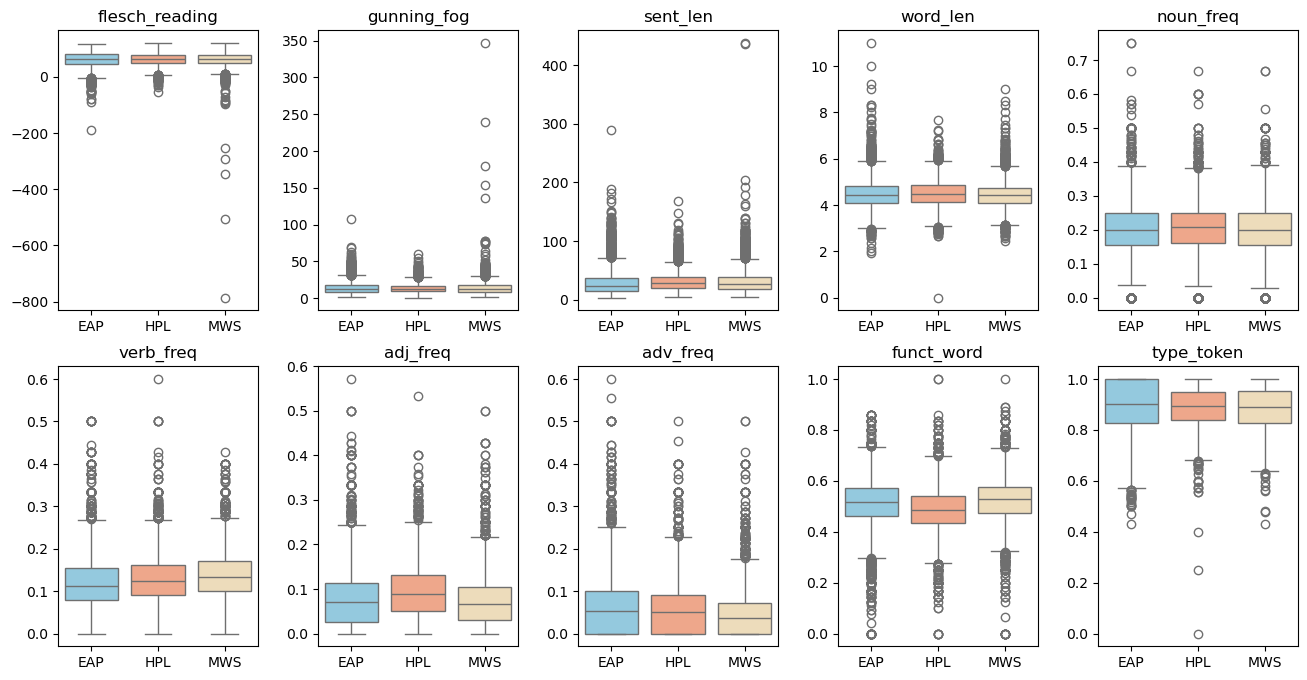

In [21]:
# Create a figure with 10 subplots (2 rows and 5 columns)
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = [16, 8])
plt.subplots_adjust(wspace = 0.3)

# Flatten the axs for easy iteration
axs = axs.flatten()

# The column names of linguistic features
lingu_cols = ['flesch_reading', 'gunning_fog', 'sent_len', 'word_len', 'noun_freq',
            'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']

# Plot the linguistic features
for i, col in enumerate(lingu_cols):
    sns.boxplot(data = clean_train, x = 'author', y = col, hue = 'author', palette = ['skyblue', 'lightsalmon', 'wheat'], ax = axs[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(col);

The plots above show slight deviations among authors in terms of linguistic features, but these differences are not very pronounced. 

I will use an ANOVA test to determine if there are statistically significant differences between the means of these features across the author groups, setting $\alpha$ = 0.05.

In [22]:
# Group the data by 'author' 
authors = clean_train['author'].unique()

# Apply ANOVA for each continuous feature across the author groups
for feature in lingu_cols:
    # Create groups for each author 
    groups = [clean_train[clean_train['author'] == author][feature] for author in authors]

    # Perform one-way ANOVA
    f_statistic, p_value = f_oneway(*groups)

    # Print results
    print(f"Feature: {feature}, p-value: {p_value: .3f}")

Feature: flesch_reading, p-value:  0.056
Feature: gunning_fog, p-value:  0.001
Feature: sent_len, p-value:  0.000
Feature: word_len, p-value:  0.000
Feature: noun_freq, p-value:  0.000
Feature: verb_freq, p-value:  0.000
Feature: adj_freq, p-value:  0.000
Feature: adv_freq, p-value:  0.000
Feature: funct_word, p-value:  0.000
Feature: type_token, p-value:  0.002


Most of the p-values are less than 0.05, suggesting that there are statistically significant differences among the means of these features across the author groups, except for the Flesch Reading Score which has a p-value of 0.056. I will remove 'flesch_reading' from the training and test set, and keep the rest linguistic features.

However, the ANOVA test only tells us that there are differences between the groups, but it doesn't specify which groups differ or in what way. I will use Tukey HSD to uncover more details.

In [23]:
# Drop the column 'flesch_reading'
clean_train = clean_train.drop(columns = ['flesch_reading'])
clean_test = clean_test.drop(columns = ['flesch_reading'])

In [24]:
columns = ['gunning_fog', 'sent_len', 'word_len', 'noun_freq',
            'verb_freq', 'adj_freq', 'adv_freq', 'funct_word', 'type_token']

# Perform TukeyHSD 
for col in columns:
    tukey = pairwise_tukeyhsd(endog = clean_train[col], groups = clean_train['author'], alpha = 0.05)
    print(col)
    print(tukey)
    print()

gunning_fog
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   EAP    HPL   0.3707 0.0205  0.0457 0.6957   True
   EAP    MWS   0.4583 0.0022  0.1398 0.7769   True
   HPL    MWS   0.0876 0.8229 -0.2576 0.4328  False
---------------------------------------------------

sent_len
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   EAP    HPL   2.0872    0.0 1.3203 2.8541   True
   EAP    MWS   1.9367    0.0  1.185 2.6883   True
   HPL    MWS  -0.1505 0.9018 -0.965 0.6639  False
--------------------------------------------------

word_len
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   EAP    HPL   0.0365 0.0009  0.0128  0.0602   True
   EAP    MWS  -0.0251 0.0305 -0.0

The Tukey HSD results show that:

* Texts by EAP are more difficult to read (higher Gunning Fog Index) and contain longer sentences than those by the other two authors.
* MWS tends to use longer words, followed by EAP, then HPL.
* EAP uses more nouns and verbs; MWS uses more nouns, adjectives, and adverbs; HPL uses more function words.
* MWS has the highest type-token ratio. 

I summarize the ranking (1 to 3) of the three authors for each linguistic feature in the table below. A ranking of 1 indicates the highest score, and equal rankings indicate no statistically significant difference between two authors for that feature.  
  

| Linguistic Features | EAP | HPL | MWS |
| :-: | :-: | :-: | :-: |
| gunning_fog | 1 | 2 | 2 |
| sent_len | 1 | 2 | 2 |
| word_len | 2 | 3 | 1 |
| noun_freq | 1 | 3 | 1 |
| verb_freq | 1 | 2 | 3 |
| adj_freq | 2 | 3 | 1 |
| adv_freq | 3 | 2 | 1 |
| funct_word | 2 | 1 | 3 |
| type_token | 2 | 2 | 1 |    
  
Now, let's check the authors' preference for particular vocabularies.    

In [25]:
# Rename the column 'author' to avoid ambiguous ('author' could be both an index level and a column label in 'tfidf_df' below)
clean_train.rename(columns = {'author': 'Author'}, inplace = True)

# Create a tfidf vectorizer 
tfidf = TfidfVectorizer(ngram_range = (1, 3), min_df = 2) 

# transform the cleaned_text in training set to a tfidf matrix 
tfidf_mx = tfidf.fit_transform(clean_train['cleaned_text'])

# Convert the document-term matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_mx.toarray(), columns = tfidf.get_feature_names_out(), 
                         index = clean_train['Author'])

# Group by author and sum the value for each author
author_term = tfidf_df.groupby('Author').sum()
author_term = author_term.reset_index()


In [27]:
# Define a function to plot top n-grams
def plot_top_ngrams(author, n_gram, top_n, ax):
    df = author_term[author_term['Author'] == author].drop(columns = 'Author').T
    df.columns = ['Frequency']
    ngrams = [ngram for ngram in df.index if len(ngram.split()) == n_gram]
    df_ngrams = df.loc[ngrams, 'Frequency'].sort_values(ascending = False).head(top_n).to_frame()

    sns.barplot(x = df_ngrams['Frequency'], y = df_ngrams.index, color = 'skyblue', ax = ax)
    ax.set_title(f'Top {top_n} {n_gram}-grams from author {author}')
    ax.set_ylabel('')

    return ax


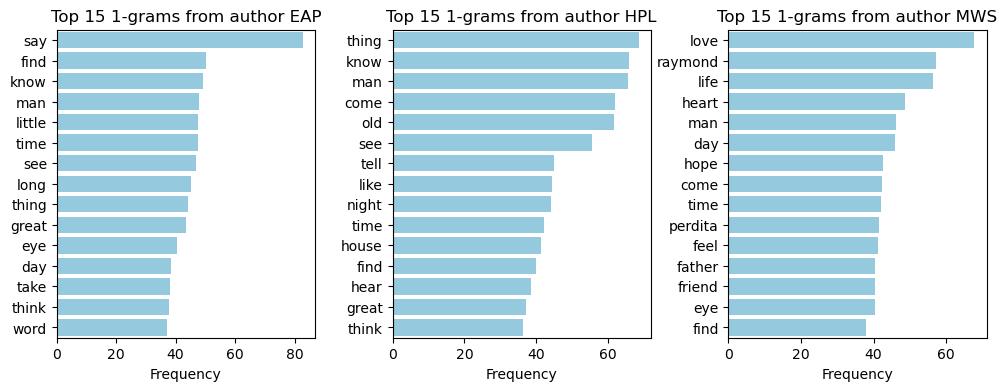

In [28]:
# Plot top unigrams
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))
plt.subplots_adjust(wspace = 0.3)

for i, author in enumerate(clean_train['Author'].unique()):
    plot_top_ngrams(author, 1, 15, ax[i])

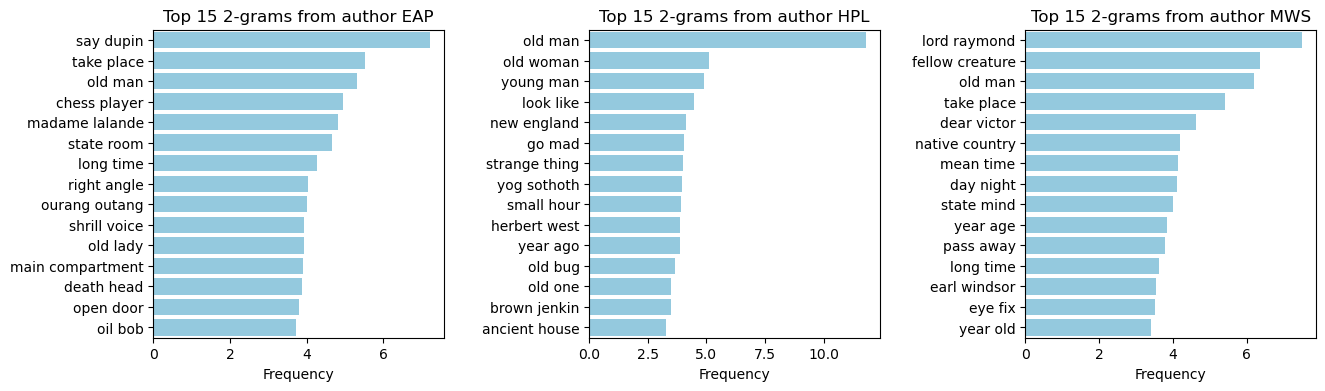

In [ ]:
# Plot top bigrams
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
plt.subplots_adjust(wspace = 0.5)

for i, author in enumerate(clean_train['Author'].unique()):
    plot_top_ngrams(author, 2, 15, ax[i])

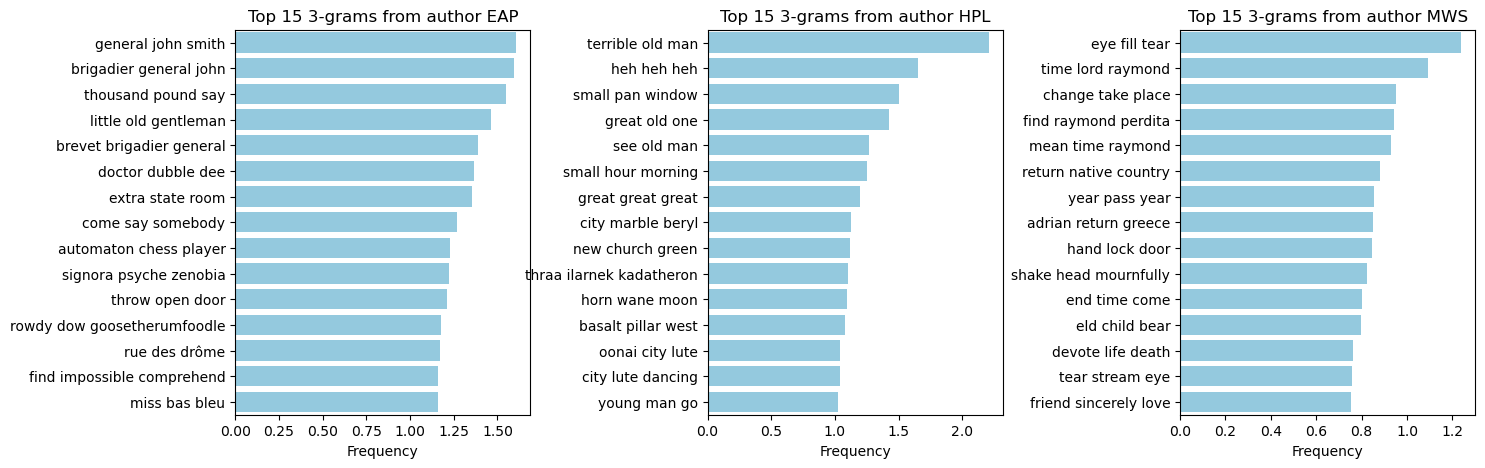

In [30]:
# Plot top trigrams
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
plt.subplots_adjust(wspace = 0.6)

for i, author in enumerate(clean_train['Author'].unique()):
    plot_top_ngrams(author, 3, 15, ax[i])

In [ ]:
# Delete the rows with empty 'cleaned_text'
clean_train = clean_train[clean_train['cleaned_text'] != '']

# Reset_index of clean_train 
clean_train = clean_train.reset_index(drop = True)

As we can see from the plots above, there are several overlapping top unigrams among the authors. However, as the value of n increases, the number of overlapping n-grams decreases. There are far fewer common bigrams and trigrams compared to unigrams. Since I removed the stop words, some of the trigrams appear a bit odd and do not convey much meaning.   

In [31]:
# Save 'clean_train' and 'clean_test'
clean_train.to_csv('clean_train.csv', index = False)
clean_test.to_csv('clean_test.csv', index = False)

##### Summary of EDA  

Here is what I have done during the EDA:

* Checked the proportion of each target label (author) in the training set and found that the dataset is roughly **balanced**. 

* Created a new column, 'author_encoded', using integers to represent the authors (**label encoding**) in order to address the challenge of model performance calculation.  
  
* Reviewed the text data and concluded that it **doesn't require much additional cleaning** beyond tokenization, lemmatization, and the removal of stop words, punctuation, digits, and short words—all of which were done by the spaCy package.  

* Explored **linguistic features** which reflect authors' writing styles through features such as Gunning Fog Index, sentence length, word length, POS Tags Distribution, function word usage, type-token ratio, and word frequency. The results of ANOVA test and TukeyHSD shows that there are statistically significant differences among the means of most linguistic features across the author groups, except for the Flesch Reading Score.

* Plotted the **top n-grams** by author and observed several overlapping top unigrams among the authors, making the distinction between them relatively small in terms of unigrams. However, as *n* increases, the number of overlapping n-grams decreases.  
  
**Potential Challenges**:   
  
The overlap of top n-grams blurs the boundaries between the authors, potentially challenging the performance of models we plan to build. **Potential solutions** include:

1. Tuning hyperparameters and considering **higher values of ngram_range** in the TF-IDF matrix to reduce the overlap of n-grams.  
  
2. Using **BERT embeddings**, which account for the context in which words appear, to see if they provide richer and more valuable information compared to TF-IDF.  
  
3. Adopting a **hybrid approach** that combines unsupervised learning models with supervised learning models.  

### Modeling  

**Word Embedding**
Based on the text data characteristics—such as overlapping top n-grams—I will use TF-IDF and BERT to determine which word embedding method works better in this case.

**Models**
* Unsupervised Model: Agglomerative clustering, Latent Dirichlet Allocation (LDA), NMF 
* Hybrid Model: combining unsupervised and supervised methods.  
    * Using unsupervised models for topic modeling and feature extraction   
    * Training supervised models on the topic/feature matrix from stage one. 
* Supervised Model: Random Forest, XGBoost


**Metrics**
This is a multi-class classification problem. As mentioned earlier, the training set from the Kaggle competition includes labels for evaluating model performance. I will use accuracy as the primary evaluation metric, while log-loss will be used for submissions, as the Kaggle competition evaluates models using multi-class logarithmic loss. Efficiency (wall time) will also be considered if the accuracies of two models are very close.


In [140]:
# Split the 'clean_train' to training and validation set
tra, val = train_test_split(clean_train, test_size = 0.2, stratify = clean_train['Author'], random_state = 1)

#### Unsupervised Model  
  
1. Agglomerative Clustering vs. LDA vs. NMF    

In [ ]:
# Create a tfidf vectorizer with most default hyperparameter setting but min_df = 2 to reduce the dimention of tfidx matrix
tfidf = TfidfVectorizer(min_df = 2)

# Fit and transform the 'cleaned_text' from 'tra' and 'val' into a tfidf-matrix (document-term matrix)
tfidf.fit(tra['cleaned_text'])
tfidf_mx_tra = tfidf.transform(tra['cleaned_text'])
tfidf_mx_val = tfidf.transform(val['cleaned_text'])

The Agglomerative clustering assigns labels randomly, I will define a function to permute the label orders and get the best accuracy score.

In [142]:
def clustering_accuracy(y_pred, y_true):
    label_orders = list(permutations([0, 1, 2]))
    y_true = y_true.reset_index(drop = True)
    accuracy = []
    for i in range(len(label_orders)):
        map_label = dict(zip(list(tra['Author'].unique()), list(label_orders[i])))
        yt = y_true.apply(lambda x: map_label[x])
        acc = accuracy_score(yt, y_pred)
        accuracy.append(acc)
    idx = np.argmax(accuracy)
    return accuracy[idx], label_orders[idx]

In [ ]:
%%time

# Train an AgglomerativeClustering model on the tfidf matrix
clutering = AgglomerativeClustering(n_clusters = 3).fit(tfidf_mx_tra.toarray())

# Get the accuracy of the clusering model
accu_clustering, label_order = clustering_accuracy(clutering.labels_, tra['Author'])
print("The accuracy of the agglomerative clustering model is", accu_clustering)

In [35]:
# Define a function to permute label orders and get best accuracy
def topic_accuracy(doc_topic, y_true):
    label_orders = list(permutations([0, 1, 2]))
    y_true = y_true.reset_index(drop = True)
    best_accu = 0
    for i in range(len(label_orders)):
        df = pd.DataFrame(doc_topic, columns = list(label_orders[i]))
        df['y_pred'] = df.idxmax(axis = 1)
        accuracy = accuracy_score(y_true, df['y_pred'])
        if accuracy > best_accu:
            best_accu = accuracy
            y_pred = df['y_pred']
    return best_accu, y_pred

In [66]:
%%time

# Train a LDA model on the TF-IDF matrix
lda = LatentDirichletAllocation(n_components = 3, random_state = 8)
lda.fit(tfidf_mx_tra)
lda_topics = lda.transform(tfidf_mx_tra)

# Get the accuracy of the LDA model
accu_lda, lda_pred = topic_accuracy(lda_topics, tra['author_encoded'])
print("lda accuracy of training set:", accu_lda)

lda accuracy of training set: 0.4318051026280453
CPU times: user 46.9 s, sys: 674 ms, total: 47.5 s
Wall time: 51.7 s


In [72]:
%%time

# Train a NMF model on the TF-IDF matrix
nmf_base = NMF(n_components = 3, random_state = 8)
nmf_base.fit(tfidf_mx_tra)

# Transform the tfidf matrix and get the W matrix
w_base = nmf_base.transform(tfidf_mx_tra)

# Get the accuracy of the NMF model
accu_nmf_base, nmf_pred_base = topic_accuracy(w_base, tra['author_encoded'])
print("nmf_base accuracy of training set:", accu_nmf_base)

nmf_base accuracy of training set: 0.3958693011062088
CPU times: user 486 ms, sys: 117 ms, total: 603 ms
Wall time: 357 ms


The accuracy of Agglomerative Clustering, LDA and NMF model is similarly low, all around 0.4. However, the runtime of Agglomerative Clustering is significantly longer than that of the NMF and LDA models. 

The LDA model performs slightly better than NMF in terms of accuracy (0.4318 vs. 0.3959), while the NMF model is more efficient than LDA (357 ms vs. 51.7 s)
Therefore, I will proceed with both LDA and NMF model for now.  

First, concatenate linguistic features and tfidf matrix then train the LDA and NMF models to see if it improves the model performance.

In [73]:
# Concatenate linguistic features and tfidf matrix
lingu_tra = tra[['gunning_fog', 'sent_len', 'word_len', 'noun_freq', 'verb_freq', 'adj_freq', 'adv_freq',
                 'funct_word', 'type_token']].to_numpy()

tfidf_lingu = np.concatenate((tfidf_mx_tra.toarray(), lingu_tra), axis = 1)

In [74]:
%%time 

# Train a LDA model on tfidf_lingu matrix
lda_tl = LatentDirichletAllocation(n_components = 3, random_state = 8)
lda_tl.fit(tfidf_lingu)
lda_tl_topics = lda_tl.transform(tfidf_lingu)

# Get the accuracy of the LDA model
accu_lda_tl, lda_tl_pred = topic_accuracy(lda_tl_topics, tra['author_encoded'])
print("lda_tl accuracy of training set:", accu_lda_tl)

lda_tl accuracy of training set: 0.3608286974870516
CPU times: user 2min 57s, sys: 3.1 s, total: 3min
Wall time: 3min 25s


In [75]:
%%time

# Train a NMF model on the tfidf_lingu matrix
nmf_tl = NMF(n_components = 3, random_state = 8)
nmf_tl.fit(tfidf_lingu)

# Transform the tfidf_lingu matrix and get the W matrix
w_tl = nmf_tl.transform(tfidf_lingu)

# Get the accuracy of the NMF model
accu_nmf_tl, nmf_tl_pred = topic_accuracy(w_tl, tra['author_encoded'])
print("nmf_tl accuracy of training set:", accu_nmf_tl)

/opt/miniconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf_tl accuracy of training set: 0.38071487946799665
CPU times: user 4min 17s, sys: 9.93 s, total: 4min 27s
Wall time: 2min 46s


Adding linguistic features to the tfidf matrix doesn't improve the models' performance, instead it prolongs the runtime. I will stick with the tf-idf matrix only and tune the hyper parameters of TF-IDF Vectorizer, LDA and NMF models.

2. Tune hyperparameter of NMF / LDA + TF-IDF  
  
First, I will tune the hyperparameter of TF-IDF Vectorizer and NMF model. To improve efficiency, I will first use RandomizedSearchCV to tune over a wide range of hyperparameters, then use GridSearchCV for a final round of tuning on a narrower parameter range.

But before that, I need to define a scoring function for RandomizedSearchCV and GridSearchCV.

In [7]:
# Define a scoring function for GridSearchCV
def accuracy(estimator, X, y):
    tfidf = estimator.named_steps['tfidf']
    tfidf_mx = tfidf.transform(X)
    topic_model = estimator.named_steps['topic_model']
    doc_topic = topic_model.transform(tfidf_mx)
    accu, y_pred = topic_accuracy(doc_topic, y)
    return accu

There are two types of solvers in the NMF model: 'cd' and 'mu'. The 'mu' solver can be tuned together with the 'beta_loss' parameter, while the 'cd' solver cannot. I will run RandomizedSearchCV separately —- once using the 'cd' solver and once using the 'mu' solver.

In [ ]:
# Create a pipeline of TfidfVectorizer + NMF using the default solver 'cd'
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english')),
    ('topic_model', NMF(n_components = 3, max_iter = 2000, random_state = 42))
])

# Create a parameter grid
params = {
    'tfidf__ngram_range': [(1, 2), (2, 2), (2, 3), (3, 3)],
    'tfidf__max_df': [0.8, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_features': [5000, 8000, None],
    'topic_model__init': ['random', 'nndsvd', 'nndsvda']
}

# Perform RandomizedSearchCV
tfidf_nmf_cd = RandomizedSearchCV(pipeline, params, n_iter = 30, scoring = accuracy, n_jobs = -1)
tfidf_nmf_cd.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
tfidf_nmf_cd.best_score_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


0.40354443309499494

In [80]:
# Create a pipeline of TfidfVectorizer + NMF using the solver 'mu' which can be tuned together with the 'beta_loss' parameter
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english')),
    ('topic_model', NMF(n_components = 3, max_iter = 2000, solver = 'mu', random_state = 42))
])

# Create a parameter grid
params = {
    'tfidf__ngram_range': [(1, 2), (2, 2), (2, 3), (3, 3)],
    'tfidf__max_df': [0.8, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__max_features': [5000, 8000, None],
    'topic_model__init': ['nndsvda', 'nndsvdar'],
    'topic_model__beta_loss': ['frobenius', 'kullback-leibler']
}

# Perform RandomizedSearchCV
tfidf_nmf_mu = RandomizedSearchCV(pipeline, params, n_iter = 60, scoring = accuracy, n_jobs = 3)
tfidf_nmf_mu.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
tfidf_nmf_mu.best_score_

0.49337552071781365

The NMF model with the 'mu' solver performs better than the one with the 'cd' solver. I will continue tuning the hyperparameters of the former (NMF with the 'mu' solver).

In [81]:
# Get the best parameter
tfidf_nmf_mu.best_params_

{'topic_model__init': 'nndsvda',
 'topic_model__beta_loss': 'kullback-leibler',
 'tfidf__ngram_range': (1, 2),
 'tfidf__min_df': 5,
 'tfidf__max_features': 8000,
 'tfidf__max_df': 1.0}

In [83]:
# Continue tuning TfidfVectorizer + NMF using the solver 'mu' 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english')),
    ('topic_model', NMF(n_components = 3, init = 'nndsvda', max_iter = 2000, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 42))
])

# Create a parameter grid
params = {
    'tfidf__ngram_range': [(1, 2), (1, 3), (2, 3)],
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [3, 4, 5],
    'tfidf__max_features': [7000, 8000, 9000, 10000],
    
}

# Perform RandomizedSearchCV
tfidf_nmf_mu2 = RandomizedSearchCV(pipeline, params, n_iter = 30, scoring = accuracy, n_jobs = 3)
tfidf_nmf_mu2.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
tfidf_nmf_mu2.best_score_


0.5082100785190449

In [84]:
# Get the best parameter
tfidf_nmf_mu2.best_params_

{'tfidf__ngram_range': (1, 2),
 'tfidf__min_df': 4,
 'tfidf__max_features': 10000,
 'tfidf__max_df': 0.85}

In [85]:
# Last round of tuning TfidfVectorizer + NMF using the solver 'mu' 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english')),
    ('topic_model', NMF(n_components = 3, init = 'nndsvda', max_iter = 2000, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 42))
])

# Create a parameter grid
params = {
    'tfidf__ngram_range': [(1, 2), (1, 3), (2, 3)],
    'tfidf__min_df': [3, 4, 5],
    'tfidf__max_df': [0.8, 0.85, 0.9],
    'tfidf__max_features': [9000, 10000, 12000]
}

# Perform GridSearchCV
tfidf_nmf_mu3 = GridSearchCV(pipeline, params, scoring = accuracy, n_jobs = -1)
tfidf_nmf_mu3.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
tfidf_nmf_mu3.best_score_

0.5082100785190449

In [86]:
# Get the best parameter
tfidf_nmf_mu3.best_params_

{'tfidf__max_df': 0.8,
 'tfidf__max_features': 9000,
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2)}

I will train the NMF model with the best parameter setting from the hyperparameter tunning, and get the accuracy and time complexity.

In [32]:
# Create a tfidf vectorizer using the best_params
tfidf_tuned = TfidfVectorizer(stop_words= 'english', min_df = 4, max_df = 0.8, max_features = 9000, ngram_range = (1, 2))

# Fit and transform the 'cleaned_text' from 'tra' into a tfidf-matrix (document-term matrix)
tfidf_tuned.fit(tra['cleaned_text'])
tfidf_tuned_mx_tra = tfidf_tuned.transform(tra['cleaned_text'])

In [37]:
%%time

# Train a NMF model on the TF-IDF matrix
nmf_tuned = NMF(n_components = 3, init = 'nndsvda', max_iter = 2000, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 36)
nmf_tuned.fit(tfidf_tuned_mx_tra)

# Transform the tfidf matrix and get the W matrix
w_tuned = nmf_tuned.transform(tfidf_tuned_mx_tra)

# Get the accuracy of the NMF model
accu_nmf_tuned, nmf_pred_tuned = topic_accuracy(w_tuned, tra['author_encoded'])
print("nmf_tuned accuracy on training set:", accu_nmf_tuned)

nmf_tuned accuracy on training set: 0.47822750815269516
CPU times: user 9.28 s, sys: 1.18 s, total: 10.5 s
Wall time: 7.33 s


The accuracy of the NMF model improved slightly, rise from 0.3959 to 0.4782, after hyperparameter tuning.

In [36]:
# Transform the 'cleaned_text' from 'val' into a tfidf matrix
tfidf_tuned_mx_val = tfidf_tuned.transform(val['cleaned_text'])

# Get W matrix
w_tuned_val = nmf_tuned.transform(tfidf_tuned_mx_val)

# Get the accuracy
accu_nmf_tuned_val, nmf_pred_tuned_val = topic_accuracy(w_tuned_val, val['author_encoded'])
print("nmf_tuned accuracy on validation set:", accu_nmf_tuned_val)


nmf_tuned accuracy on validation set: 0.4792838874680307


Now I will tune hyperparameter of the LDA model.

In [120]:
# Create a pipeline of TfidfVectorizer + LDA 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english')),
    ('topic_model', LatentDirichletAllocation(n_components = 3, random_state = 16))
])

# Create a parameter grid
params = {
    'tfidf__ngram_range': [(1, 2), (1, 3), (2, 2), (2, 3), (3, 3)],
    'tfidf__max_df': [0.8, 1.0],
    'tfidf__min_df': [1, 3, 5],
    'tfidf__max_features': [5000, 8000, None],
    'topic_model__doc_topic_prior': [None, 0.2, 0.4],
    'topic_model__learning_decay': [0.6, 0.7, 0.8]
}

# Perform RandomizedSearchCV
rsv_lda0 = RandomizedSearchCV(pipeline, params, n_iter = 100, scoring = accuracy, n_jobs = 3)
rsv_lda0.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
rsv_lda0.best_score_

0.48984489200932463

In [121]:
rsv_lda0.best_params_

{'topic_model__learning_decay': 0.8,
 'topic_model__doc_topic_prior': 0.2,
 'tfidf__ngram_range': (1, 2),
 'tfidf__min_df': 5,
 'tfidf__max_features': 8000,
 'tfidf__max_df': 0.8}

In [8]:
# Create a pipeline of TfidfVectorizer + LDA 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english')),
    ('topic_model', LatentDirichletAllocation(n_components = 3, random_state = 8))
])

# Create a parameter grid
params = {
    'tfidf__ngram_range': [(1, 2), (1, 3), (2, 3)],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'tfidf__min_df': [4, 5, 6],
    'tfidf__max_features': [6000, 8000, 10000],
    'topic_model__doc_topic_prior': [0.1, 0.2, 0.3],
    'topic_model__learning_decay': [0.7, 0.8, 0.9]
}

# Perform RandomizedSearchCV
rsv_lda1 = RandomizedSearchCV(pipeline, params, n_iter = 30, scoring = accuracy, n_jobs = 3)
rsv_lda1.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
rsv_lda1.best_score_

0.5079561560017247

In [9]:
# Get the best parameters
rsv_lda1.best_params_

{'topic_model__learning_decay': 0.9,
 'topic_model__doc_topic_prior': 0.1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__min_df': 6,
 'tfidf__max_features': 6000,
 'tfidf__max_df': 0.8}

In [10]:
# Create a pipeline of TfidfVectorizer + LDA 
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words= 'english', max_df = 0.8, ngram_range = (1, 2))),
    ('topic_model', LatentDirichletAllocation(n_components = 3, random_state = 8))
])

# Create a parameter grid
params = {
    'tfidf__min_df': [5, 6, 7],
    'tfidf__max_features': [5000, 6000, 7000],
    'topic_model__doc_topic_prior': [0.1, 0.2, 0.25],
    'topic_model__learning_decay': [0.8, 0.85, 0.9] 
}

# Perform RandomizedSearchCV
gsv_lda2 = GridSearchCV(pipeline, params, scoring = accuracy, n_jobs = 3)
gsv_lda2.fit(clean_train['cleaned_text'], clean_train['author_encoded'])

# Get the best score
gsv_lda2.best_score_

0.5079561560017247

In [11]:
gsv_lda2.best_params_

{'tfidf__max_features': 6000,
 'tfidf__min_df': 6,
 'topic_model__doc_topic_prior': 0.1,
 'topic_model__learning_decay': 0.8}

I will train the LDA model with the best parameter setting from the hyperparameter tunning, and get the accuracy and time complexity.

In [47]:
# Create a tfidf vectorizer using the best_params
tfidf_lda_tuned = TfidfVectorizer(stop_words= 'english', max_df = 0.8, min_df = 6, max_features = 6000, ngram_range = (1, 2))

# Fit and transform the 'cleaned_text' from 'tra' into a tfidf-matrix (document-term matrix)
tfidf_lda_tuned.fit(tra['cleaned_text'])
tfidf_lda_tra = tfidf_lda_tuned.transform(tra['cleaned_text'])

In [48]:
%%time 

# Train a LDA model on the TF-IDF matrix
lda_tuned = LatentDirichletAllocation(n_components = 3, learning_decay = 0.8, doc_topic_prior = 0.1, random_state = 8)
lda_tuned.fit(tfidf_lda_tra)
lda_tuned_topics = lda_tuned.transform(tfidf_lda_tra)

# Get the accuracy of the LDA model
accu_lda_tuned, lda_tuned_pred = topic_accuracy(lda_tuned_topics, tra['author_encoded'])
print("lda accuracy of training set:", accu_lda_tuned)

lda accuracy of training set: 0.45009271692563463
CPU times: user 19.3 s, sys: 286 ms, total: 19.6 s
Wall time: 21.8 s


The performance of LDA model improved slightly after hyperparameter tuning, the accuracy rising from 0.4069 to 0.45.

In [49]:
# Transform the 'cleaned_text' from 'val' into a tfidf matrix
tfidf_lda_val = tfidf_lda_tuned.transform(val['cleaned_text'])

# Get document-topic matrix
lda_tuned_topics_val = lda_tuned.transform(tfidf_lda_val)

# Get the accuracy
accu_lda_tuned_val, lda_pred_tuned_val = topic_accuracy(lda_tuned_topics_val, val['author_encoded'])
print("lda_tuned accuracy on validation set:", accu_lda_tuned_val)


lda_tuned accuracy on validation set: 0.4785166240409207


3. Bert Embedding + NMF

In [64]:
# Load bert tokenizer and bert base model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [16]:
# Check the length of text data
print(tra.text.apply(lambda x: len(x.split())).describe()) 
print()

# Check the proportion of text length greater than 80
print('Proportion of text length greater than 80:', 
      round((tra.text.apply(lambda x: len(x.split())) > 80).sum() / len(clean_train), 3))

count    15639.000000
mean        26.749025
std         18.810679
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: text, dtype: float64

Proportion of text length greater than 80: 0.01


In [63]:
# Define a function to extract the pooled_output of the Bert embedding
def bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors = 'pt', padding = True, truncation = True,
                            add_special_tokens = True, max_length = 80)
    outputs = bert_model(**inputs)

    pooled_output = outputs.pooler_output.detach().numpy().tolist()
    pooled = [ele for sublist in pooled_output for ele in sublist]

    return pooled

In [18]:
# Reset index of the training and validation set to ensure that the following code, which references the index, works correctly
tra = tra.reset_index(drop = True)
val = val.reset_index(drop = True)

# Apply bert embedding on the text data of the 'tra' dataset
pooled_output = []

for i in range(tra.shape[0]):
    pooled = bert_embedding(tra['text'][i])
    pooled_output.append(pooled)

pooled_output_tra = pd.DataFrame(pooled_output, columns = range(768))

In [19]:
# Apply bert embedding on the text data of the 'val' dataset
pooled_output_val = []

for i in range(val.shape[0]):
    pooled = bert_embedding(val['text'][i])
    pooled_output_val.append(pooled)

pooled_output_val = pd.DataFrame(pooled_output_val, columns = range(768))

In [ ]:
# Apply bert embedding on the text data of the test dataset
pooled_output_test = []

for i in range(clean_test.shape[0]):
    pooled = bert_embedding(clean_test['text'][i])
    pooled_output_test.append(pooled)

pooled_output_test = pd.DataFrame(pooled_output_test, columns = range(768))

In [ ]:
# Shift pooled_output_tra by + 1 to make it non-negative
pooled_output_tra = pooled_output_tra + 1
pooled_output_val = pooled_output_val + 1
pooled_output_test = pooled_output_test + 1

In [ ]:
# Save 'pooled_output_tra' and 'pooled_output_val'
pooled_output_tra.to_csv('pooled_output_tra.csv', index= False)
pooled_output_val.to_csv('pooled_output_val.csv', index = False)
pooled_output_test.to_csv('pooled_output_test.csv', index= False)

In [23]:
%%time 

# Train a NMF on the Bert Embedding
nmf_bert = NMF(n_components= 3, max_iter = 2000, random_state = 36)
nmf_bert.fit(pooled_output_tra)
w_bert = nmf_bert.transform(pooled_output_tra)

# Get accuracy score
accu_nmf_bert, nmf_pred_bert = topic_accuracy(w_bert, tra['author_encoded'])
print("The accuracy of the nmf model is", accu_nmf_bert)

The accuracy of the nmf model is 0.3759831191252638
CPU times: user 29.4 s, sys: 973 ms, total: 30.4 s
Wall time: 18.5 s


In [15]:
# Define a scoring function for GridSearchCV
def accuracy_bert(estimator, X, y):
    w = estimator.transform(X)
    accu, y_pred = topic_accuracy(w, y)
    return accu

In [206]:
# Tune hyperparameter of the NMF model with solver 'cd'
params = {
    'init': ['random', 'nndsvd', 'nndsvda']
}

gsv_bert_nmf = GridSearchCV(estimator = NMF(n_components= 3, max_iter = 2000, random_state = 16),
                            param_grid = params, scoring = accuracy_bert, cv = 3, n_jobs = -1)
gsv_bert_nmf.fit(pooled_output_tra, tra['author_encoded'])
gsv_bert_nmf.best_score_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


0.3819830173019217

In [26]:
# Tune hyperparameter of the NMF model with solver 'mu'
params = {
    'init': ['nndsvda', 'nndsvdar'],
    'beta_loss': ['frobenius', 'kullback-leibler']
}

bert_nmf_mu = GridSearchCV(estimator = NMF(n_components= 3, solver = 'mu', max_iter = 2000, random_state = 16),
                            param_grid = params, scoring = accuracy_bert, cv = 3, n_jobs = 3)
bert_nmf_mu.fit(pooled_output_tra, tra['author_encoded'])
bert_nmf_mu.best_score_

0.3877485772747618

In [208]:
bert_nmf_mu.best_params_

{'beta_loss': 'kullback-leibler', 'init': 'nndsvdar'}

In [ ]:
%%time 

# Train a NMF with solver of 'mu' on the pooled_output_tra
nmf_bert_mu = NMF(n_components= 3, solver = 'mu', init = 'nndsvdar', beta_loss = 'kullback-leibler', max_iter = 2000, random_state = 8)
nmf_bert_mu.fit(pooled_output_tra)
w_bert_mu = nmf_bert_mu.transform(pooled_output_tra)

# Get accuracy score
accu_nmf_bert_mu, nmf_pred_bert_mu = topic_accuracy(w_bert_mu, tra['author_encoded'])
print("The accuracy of the nmf model is", accu_nmf_bert_mu)

The accuracy of the nmf model is 0.38723703561608797
CPU times: user 4min 26s, sys: 55.3 s, total: 5min 21s
Wall time: 3min 9s


In [ ]:
# Transform pooled_output_val to W matrix
w_bert_mu_val = nmf_bert_mu.transform(pooled_output_val)

# Get test accuracy 
accu_nmf_bert_val, nmf_pred_bert_mu = topic_accuracy(w_bert_mu_val, val['author_encoded'])
print("The test accuracy of nmf_bert_mu is", accu_nmf_bert_val)

The test accuracy of nmf_bert_mu is 0.3867007672634271


The NMF model trained on BERT embeddings performs much worse than the one trained on the TF-IDF matrix in terms of accuracy. 

The models' performance doesn't improve much with the first two potential solutions I proposed at the end of the EDA section, especially not with BERT Embedding. Results are shown below:

**Agglomerative clustering vs. LDA vs. NMF**
| Model | Train Accuracy | Wall time | Description |
| :-: | :-: | :-: |  :-  |
| clustering | 0.3995 | 22mins 36s | Agglomerative clustering trained on TF-IDF |
| nmf_base | 0.3959 | 357 ms | NMF trained on TF-IDF |
| lda | 0.4069 | 47 s | LDA trained on TF-IDF |

**Tuned LDA and NMF Model**
| Model | Train Accuracy | Wall time | Test Accuracy | Description |
| :-: | :-: | :-: |  :-:  |  :-  |
| nmf_tuned | 0.4782 | 6.98 s | 0.4793 | NMF trained on TF-IDF with tuned hyperparameter |  
| lda_tuned | 0.4501 | 22.7 s | 0.4785 | LDA  trained on TF-IDF with tuned hyperparameter |    

**NMF trained on BERT Embedding**
| Model | Train Accuracy | Wall time | Description |
| :-: | :-: | :-: |  :-  |
| nmf_bert | 0.376 | 18.5 s | NMF trained on BERT embeddings with default parameter setting |
| nmf_bert_mu | 0.3872 | 3min 29s | NMF trained on BERT embeddings with tuned hyperparameter |   

Interestingly, although the train accuracy of the lda_tuned model is lower than that of the nmf_tuned model, their test accuracy is very close to each other. 
 
The results above indicate that the first two potential solutions proposed at the end of the EDA section did not yield significant improvements. Next, I will explore a third approach: building a hybrid model that combines unsupervised and supervised learning techniques.

#### Hybrid model

Building the hybrid model involves two stages:

**Stage One**: Using unsupervised models for topic modeling and feature extraction. Specifically, I trained NMF and LDA models on the TF-IDF matrix for topic modeling and applied PCA on BERT embeddings to extract features that explain 95% of the total variance.  
  
**Stage Two**: Training supervised models on the hybrid feature matrix created by combining the outputs from Stage One (topic distributions and principal components) for classification.

1. Document-topic matrices with n_components = 3

In [ ]:
# Reduce the dimension of BERT Embedding using PCA
pca = PCA(n_components= 0.95).fit(pooled_output_tra)
tra_pca = pca.transform(pooled_output_tra)
val_pca = pca.transform(pooled_output_val)

In [107]:
tra_pca.shape

(15639, 30)

In [108]:
# Concatenate two doc-topic matrices from NMF and LDA, and the dimensional reduced BERT Embedding into one
doc_topic_tra = np.concatenate((w_tuned, lda_tuned_topics, tra_pca), axis = 1)

# Concatenate two doc-topic matrices from validation set into one
doc_topic_val = np.concatenate((w_tuned_val, lda_tuned_topics_val, val_pca), axis = 1)

# Train a random forest on the w matrix
rf = RandomForestClassifier(class_weight = 'balanced', random_state = 42)
rf.fit(doc_topic_tra, tra['author_encoded'])
accuracy_score(val['author_encoded'], rf.predict(doc_topic_val))

0.7051150895140665

I first trained a Random Forest model on the hybrid feature matrix, where the number of components (n_components) in the NMF and LDA models was set to 3. The hybrid matrix was created using the document-topic matrices generated by the tuned NMF (nmf_tuned) and LDA (lda_tuned) models, along with the dimensionality reduced BERT Embedding, as mentioned above.   
  
The test accuracy is 0.7051, representing a significant improvement compared to the accuracy of the unsupervised models alone.  

2. Experiment with various numbers of components  

The low accuracy of the unsupervised models suggests that they struggled to distinguish between the three authors based on their writing, indicating that the differences in their writing and vocabulary usage are not pronounced. This is unsurprising, as all their writings belong to the same genre: horror stories. I’m wondering if there are some underlying topics within the text that could be used to identify the authors.

To explore this, I plan to experimente with a range of different numbers of components, spanning from 3 to 20. However, iterating through all combinations of different n values across the three models will take a long time. To improve efficiency and achieve a relatively good result, I decided to run a few iterations with random combinations, similar to how RandomizedSearchCV works.

In [ ]:
train_accu_0 = []
test_accu_0 = []
num_comps_0 = []

for i in range(30):
    # Get w-matrix from NMF model trained on TF-IDF 
    nmf_comp = np.random.randint(3, 20)
    nmf = NMF(n_components = nmf_comp, init = 'nndsvda', max_iter = 2000, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 8)
    nmf.fit(tfidf_tuned_mx_tra)
    w_tra = nmf.transform(tfidf_tuned_mx_tra)
    w_val = nmf.transform(tfidf_tuned_mx_val)

    # Get doc-topic matrix from LDA model
    lda_comp = np.random.randint(3, 20)
    lda = LatentDirichletAllocation(n_components = lda_comp, learning_decay = 0.8, doc_topic_prior = 0.1, random_state = 8)
    lda.fit(tfidf_lda_tra)
    lda_topics_tra = lda.transform(tfidf_lda_tra)
    lda_topics_val = lda.transform(tfidf_lda_val)

    # Concatenate the doc-topic matrices and the dimensional reduced BERT Embedding
    dt_tra = np.concatenate((w_tra, lda_topics_tra, tra_pca), axis = 1)
    dt_val = np.concatenate((w_val, lda_topics_val, val_pca), axis = 1)

    # Train a random forest on dt_tra
    rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = 3, random_state = 42)
    rf.fit(dt_tra, tra['author_encoded'])
    train_accuracy = accuracy_score(tra['author_encoded'], rf.predict(dt_tra))
    test_accuracy = accuracy_score(val['author_encoded'], rf.predict(dt_val))

    train_accu_0.append(train_accuracy)
    test_accu_0.append(test_accuracy)
    num_comps_0.append((nmf_comp, lda_comp))


In [84]:
accu_df = pd.DataFrame({
    'n_components': num_comps_0,
    'train_accuracy': train_accu_0,
    'test_accuracy': test_accu_0
})

accu_df.sort_values(by = 'test_accuracy', ascending = False, inplace = True)

print('Top 5:')
print(accu_df.head())
print('Last 5:')
print(accu_df.tail())

Top 5:
   n_components  train_accuracy  test_accuracy
6        (9, 3)             1.0       0.729412
13      (10, 3)             1.0       0.724808
9       (10, 6)             1.0       0.722251
4       (14, 9)             1.0       0.721995
12      (14, 7)             1.0       0.721483
Last 5:
   n_components  train_accuracy  test_accuracy
21       (6, 7)             1.0       0.704348
22     (18, 13)             1.0       0.704092
16       (7, 9)             1.0       0.704092
18       (4, 3)             1.0       0.703836
26     (19, 12)             1.0       0.699233


In [ ]:
for i in range(30):
    # Get w-matrix from NMF model trained on TF-IDF 
    nmf_comp = np.random.randint(8, 15)
    nmf = NMF(n_components = nmf_comp, init = 'nndsvda', max_iter = 2000, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 8)
    nmf.fit(tfidf_tuned_mx_tra)
    w_tra = nmf.transform(tfidf_tuned_mx_tra)
    w_val = nmf.transform(tfidf_tuned_mx_val)

    # Get doc-topic matrix from LDA model
    lda_comp = np.random.randint(3, 11)
    lda = LatentDirichletAllocation(n_components = lda_comp, learning_decay = 0.8, doc_topic_prior = 0.1, random_state = 8)
    lda.fit(tfidf_lda_tra)
    lda_topics_tra = lda.transform(tfidf_lda_tra)
    lda_topics_val = lda.transform(tfidf_lda_val)

    # Concatenate the doc-topic matrices and the dimensional reduced BERT Embedding
    dt_tra = np.concatenate((w_tra, lda_topics_tra, tra_pca), axis = 1)
    dt_val = np.concatenate((w_val, lda_topics_val, val_pca), axis = 1)

    # Train a random forest on dt_tra
    rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = 3, random_state = 42)
    rf.fit(dt_tra, tra['author_encoded'])
    train_accuracy = accuracy_score(tra['author_encoded'], rf.predict(dt_tra))
    test_accuracy = accuracy_score(val['author_encoded'], rf.predict(dt_val))

    train_accu_0.append(train_accuracy)
    test_accu_0.append(test_accuracy)
    num_comps_0.append((nmf_comp, lda_comp))

In [96]:
accu_df = pd.DataFrame({
    'n_components': num_comps_0,
    'train_accuracy': train_accu_0,
    'test_accuracy': test_accu_0
})

accu_df.sort_values(by = 'test_accuracy', ascending = False, inplace = True)
accu_df.drop_duplicates(subset = ['n_components'], inplace = True)

print('Top 5:')
print(accu_df.head())
print('Last 5:')
print(accu_df.tail())

Top 5:
   n_components  train_accuracy  test_accuracy
6        (9, 3)             1.0       0.729412
41      (10, 5)             1.0       0.727366
42       (8, 6)             1.0       0.725320
13      (10, 3)             1.0       0.724808
52       (9, 7)             1.0       0.724041
Last 5:
   n_components  train_accuracy  test_accuracy
21       (6, 7)             1.0       0.704348
16       (7, 9)             1.0       0.704092
22     (18, 13)             1.0       0.704092
18       (4, 3)             1.0       0.703836
26     (19, 12)             1.0       0.699233


In [ ]:
for i in [8, 9, 10]:
    for j in range(3, 9):
        # Get w-matrix from NMF model trained on TF-IDF 
        nmf = NMF(n_components = i, init = 'nndsvda', max_iter = 2000, solver = 'mu', beta_loss = 'kullback-leibler', random_state = 8)
        nmf.fit(tfidf_tuned_mx_tra)
        w_tra = nmf.transform(tfidf_tuned_mx_tra)
        w_val = nmf.transform(tfidf_tuned_mx_val)

        # Get doc-topic matrix from LDA model
        lda = LatentDirichletAllocation(n_components = j, learning_decay = 0.8, doc_topic_prior = 0.1, random_state = 8)
        lda.fit(tfidf_lda_tra)
        lda_topics_tra = lda.transform(tfidf_lda_tra)
        lda_topics_val = lda.transform(tfidf_lda_val)

        # Concatenate the doc-topic matrices and the dimensional reduced BERT Embedding
        dt_tra = np.concatenate((w_tra, lda_topics_tra, tra_pca), axis = 1)
        dt_val = np.concatenate((w_val, lda_topics_val, val_pca), axis = 1)

        # Train a random forest on dt_tra
        rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = 3, random_state = 42)
        rf.fit(dt_tra, tra['author_encoded'])
        train_accuracy = accuracy_score(tra['author_encoded'], rf.predict(dt_tra))
        test_accuracy = accuracy_score(val['author_encoded'], rf.predict(dt_val))

        train_accu_0.append(train_accuracy)
        test_accu_0.append(test_accuracy)
        num_comps_0.append((i, j))

In [98]:
accu_df = pd.DataFrame({
    'n_components': num_comps_0,
    'train_accuracy': train_accu_0,
    'test_accuracy': test_accu_0
})

accu_df.sort_values(by = 'test_accuracy', ascending = False, inplace = True)
accu_df.drop_duplicates(subset = ['n_components'], inplace = True)

print('Top 5:')
print(accu_df.head())
print('Last 5:')
print(accu_df.tail())

Top 5:
   n_components  train_accuracy  test_accuracy
62       (8, 5)             1.0       0.732737
61       (8, 4)             1.0       0.732225
64       (8, 7)             1.0       0.729668
6        (9, 3)             1.0       0.729412
65       (8, 8)             1.0       0.727877
Last 5:
   n_components  train_accuracy  test_accuracy
21       (6, 7)             1.0       0.704348
16       (7, 9)             1.0       0.704092
22     (18, 13)             1.0       0.704092
18       (4, 3)             1.0       0.703836
26     (19, 12)             1.0       0.699233


The best test accuracy of the Hybrid model with random forest is 0.7327 when the number of components for the NMF and LDA model are 8 and 5, respectively. I will extract the document-topic matrices from the two models using these corresponding settings for n_components.

In [ ]:
# Get w-matrix from NMF model 
nmf = NMF(n_components = 8, solver = 'mu', init = 'nndsvda', max_iter = 2000, beta_loss = 'kullback-leibler', random_state = 8)
nmf.fit(tfidf_tuned_mx_tra)
w_tra = nmf.transform(tfidf_tuned_mx_tra)
w_val = nmf.transform(tfidf_tuned_mx_val)

# Get doc-topic matrix from LDA model
lda = LatentDirichletAllocation(n_components = 5, learning_decay = 0.8, doc_topic_prior = 0.1, random_state = 8)
lda.fit(tfidf_lda_tra)
lda_topics_tra = lda.transform(tfidf_lda_tra)
lda_topics_val = lda.transform(tfidf_lda_val)

# Concatenate doc-topic matrices and the dimensional reduced BERT Embedding
dt_tra3 = np.concatenate((w_tra, lda_topics_tra, tra_pca), axis = 1)
dt_val3 = np.concatenate((w_val, lda_topics_val, val_pca), axis = 1)

# Train a random forest on dt_tra3
rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = 3, random_state = 42)
rf.fit(dt_tra3, tra['author_encoded'])
train_accuracy = accuracy_score(tra['author_encoded'], rf.predict(dt_tra3))
test_accuracy = accuracy_score(val['author_encoded'], rf.predict(dt_val3))

print(train_accuracy, test_accuracy)

1.0 0.7327365728900256


I will train XGBoost, LightGBM and CatBoost on dt_tra3 and get the accuracy on validation set.

In [125]:
# Train a XGBoost on dt_tra3
sample_weights = compute_sample_weight(class_weight = 'balanced', y = tra['author_encoded'])
xgb = XGBClassifier(objective = 'multi:softmax', num_class = 3, random_state = 42)
xgb.fit(dt_tra3, tra['author_encoded'], sample_weight = sample_weights)

# Get accuracy score
print('Train accuracy of XGBoost:', accuracy_score(tra['author_encoded'], xgb.predict(dt_tra3)))
print('Test Accuracy of XGBoost:', accuracy_score(val['author_encoded'], xgb.predict(dt_val3)))

Train accuracy of XGBoost: 0.9900249376558603
Test Accuracy of XGBoost: 0.7501278772378517


In [124]:
# Train a LightGBM on dt_tra3
lgb = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, verbose = 0, random_state = 42)
lgb.fit(dt_tra3, tra['author_encoded'])

# Get accuracy score
print('Train accuracy of lgb:', accuracy_score(tra['author_encoded'], lgb.predict(dt_tra3)))
print('Test Accuracy of lgb:', accuracy_score(val['author_encoded'], lgb.predict(dt_val3)))

Train accuracy of lgb: 0.8997378348999296
Test Accuracy of lgb: 0.7521739130434782


In [126]:
# Train a CatBoost on dt_tra3
classes = np.unique(tra['author_encoded'])
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = tra['author_encoded'])
class_weights = dict(zip(classes, weights))

cb = CatBoostClassifier(loss_function = 'MultiClass', class_weights = class_weights, silent = True)
cb.fit(dt_tra3, tra['author_encoded'])

print('Train accuracy of cb:', accuracy_score(tra['author_encoded'], cb.predict(dt_tra3)))
print('Test Accuracy of cb:', accuracy_score(val['author_encoded'], cb.predict(dt_val3)))

Train accuracy of cb: 0.9394462561544856
Test Accuracy of cb: 0.7529411764705882


The result of the four Hybrid models training on 'dt_tra3' is as following:

| Model | Train Accuracy | Test Accuracy |
| :-: | :-: | :-: |
| Random Forest | 1 | 0.7327 |
| XGBoost | 0.9929 | 0.7501 | 
| LightGBM | 0.8997 | 0.7522 |
| CatBoost | 0.9394 | 0.7529 |  

3. Include linguistic features to the hybrid feature matrix

Now I will reintroduce the linguistic features into the training process to evaluate whether they improve the performance of the classification models.

In [101]:
# Convert dt_tra3 into a data frame
dt_tra = pd.DataFrame(dt_tra3, columns = [f'topic_nmf{i}' for i in range(8)] + [f'topic_lda{i}' for i in range(5)] + [f'bert_pca{i}' for i in range(30)])

# Concatenate 'dt_tra' with linguistic features
dt_lingu_tra = pd.concat([dt_tra, tra[['gunning_fog', 'sent_len',
       'word_len', 'noun_freq', 'verb_freq', 'adj_freq', 'adv_freq',
       'funct_word', 'type_token']]], axis = 1)

dt_lingu_tra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15639 entries, 0 to 15638
Data columns (total 52 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   topic_nmf0   15639 non-null  float64
 1   topic_nmf1   15639 non-null  float64
 2   topic_nmf2   15639 non-null  float64
 3   topic_nmf3   15639 non-null  float64
 4   topic_nmf4   15639 non-null  float64
 5   topic_nmf5   15639 non-null  float64
 6   topic_nmf6   15639 non-null  float64
 7   topic_nmf7   15639 non-null  float64
 8   topic_lda0   15639 non-null  float64
 9   topic_lda1   15639 non-null  float64
 10  topic_lda2   15639 non-null  float64
 11  topic_lda3   15639 non-null  float64
 12  topic_lda4   15639 non-null  float64
 13  bert_pca0    15639 non-null  float64
 14  bert_pca1    15639 non-null  float64
 15  bert_pca2    15639 non-null  float64
 16  bert_pca3    15639 non-null  float64
 17  bert_pca4    15639 non-null  float64
 18  bert_pca5    15639 non-null  float64
 19  bert

In [102]:
# Convert dt_val3 into a data frame
dt_val = pd.DataFrame(dt_val3, columns = [f'topic_nmf{i}' for i in range(8)] + [f'topic_lda{i}' for i in range(5)] + [f'bert_pca{i}' for i in range(30)])

# Concatenate 'dt_val' with linguistic features
dt_lingu_val = pd.concat([dt_val, val[['gunning_fog', 'sent_len',
       'word_len', 'noun_freq', 'verb_freq', 'adj_freq', 'adv_freq',
       'funct_word', 'type_token']]], axis = 1)

dt_lingu_val.shape

(3910, 52)

In [109]:
# Save the dataframes
dt_lingu_tra.to_csv('dt_lingu_tra.csv', index = False)
dt_lingu_val.to_csv('dt_lingu_val.csv', index = False)
tra.to_csv('tra.csv', index = False)
val.to_csv('val.csv', index = False)

In [103]:
# Train a random forest model on the dt_lingu_tra
rf_dl = RandomForestClassifier(class_weight= 'balanced', random_state = 42)
rf_dl.fit(dt_lingu_tra, tra['author_encoded'])

# Get accuracy score
print('Train accuracy of Random Forest:', accuracy_score(tra['author_encoded'], rf_dl.predict(dt_lingu_tra)))
print('Test Accuracy of Random Forest:', accuracy_score(val['author_encoded'], rf_dl.predict(dt_lingu_val)))

Train accuracy of Random Forest: 1.0
Test Accuracy of Random Forest: 0.7301790281329923


In [ ]:
# Train a XGBoost on the dt_lingu_tra with sample weight adjusted
sample_weights = compute_sample_weight(class_weight = 'balanced', y = tra['author_encoded'])
xgb_dl = XGBClassifier(objective = 'multi:softmax', num_class = 3, random_state = 42)
xgb_dl.fit(dt_lingu_tra, tra['author_encoded'], sample_weight = sample_weights)

# Get accuracy score
print('Train accuracy of XGBoost:', accuracy_score(tra['author_encoded'], xgb_dl.predict(dt_lingu_tra)))
print('Test Accuracy of XGBoost:', accuracy_score(val['author_encoded'], xgb_dl.predict(dt_lingu_val)))

Train accuracy of XGBoost: 0.9929023594859007
Test Accuracy of XGBoost: 0.7570332480818415


In [ ]:
# Train a LightGBM on the dt_lingu_tra
lgb_dl = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, verbose = 0, random_state = 42)
lgb_dl.fit(dt_lingu_tra, tra['author_encoded'])

# Get accuracy score
print('Train accuracy of lgb:', accuracy_score(tra['author_encoded'], lgb_dl.predict(dt_lingu_tra)))
print('Test Accuracy of lgb:', accuracy_score(val['author_encoded'], lgb_dl.predict(dt_lingu_val)))

Train accuracy of lgb: 0.9077306733167082
Test Accuracy of lgb: 0.7654731457800511


In [106]:
# Train a CatBoost on the dt_lingu_tra
classes = np.unique(tra['author_encoded'])
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = tra['author_encoded'])
class_weights = dict(zip(classes, weights))

cb_dl = CatBoostClassifier(loss_function = 'MultiClass', class_weights = class_weights, silent = True)
cb_dl.fit(dt_lingu_tra, tra['author_encoded'])

print('Train accuracy of cb:', accuracy_score(tra['author_encoded'], cb_dl.predict(dt_lingu_tra)))
print('Test Accuracy of cb:', accuracy_score(val['author_encoded'], cb_dl.predict(dt_lingu_val)))

Train accuracy of cb: 0.9423236779845259
Test Accuracy of cb: 0.7624040920716113


The test accuracies of the four models are similar, with LightGBM performing slightly better and CatBoost coming in second. The performance of three out of four models improved after including linguistic features in the training set, so I will retain the linguistic features.

| Model | Train Accuracy | Test Accuracy |
| :-: | :-: | :-: |
| Random Forest | 1 | 0.7302 |
| XGBoost | 0.9929 | 0.7570 | 
| LightGBM | 0.9077 | 0.7655 |
| CatBoost | 0.9423 | 0.7624 |  

  
4. Hyperparameters tuning and ensemble
  
 Next, I will tune the hyperparameter of these four models. But before that, let's combine 'dt_lingu_tra' and 'dt_lingu_val' into one entire training set.  


In [110]:
# Combine dt_lingu_tra and dt_lingu_val into one entire training set
dt_lingu_train = pd.concat([dt_lingu_tra, dt_lingu_val], axis = 0)
dt_lingu_label = pd.concat([tra[['author_encoded']], val[['author_encoded']]], axis = 0)

In [111]:
# Save dt_lingu_train and dt_lingu_label
dt_lingu_train.to_csv('dt_lingu_train.csv', index = False)
dt_lingu_label.to_csv('dt_lingu_label.csv', index = False)

In [112]:
# Create a parameter grid
params = {
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [3, 7, 10, None],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 4, 7],
    'max_samples': [0.5, 0.75, 1]
}

# Tune hyperparameter of Random Forest model
rsv_rf0 = RandomizedSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced', random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_rf0.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_rf0.best_score_

0.7309839906465438

In [113]:
rsv_rf0.best_params_

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_samples': 0.5,
 'max_depth': None}

In [114]:
# Create a parameter grid
params = {
    'n_estimators': [300, 400, 500],
    'max_depth': [4, 7, 10, None],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 5],
    'max_samples': [0.5, 0.6, 0.75]
}

# Tune hyperparameter of Random Forest model
rsv_rf1 = RandomizedSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced', random_state = 8),
                      param_distributions = params, n_iter = 50, scoring = 'accuracy', n_jobs = 3)
rsv_rf1.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_rf1.best_score_

0.7318536998035226

In [115]:
rsv_rf1.best_params_

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_samples': 0.6,
 'max_depth': None}

In [116]:
# Create a parameter grid
params = {
    'n_estimators': [200, 300, 400],
    'min_samples_split': [5, 6, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_samples': [0.5, 0.6, 0.7]
}

# Tune hyperparameter of Random Forest model
rsv_rf2 = RandomizedSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced', random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_rf2.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_rf2.best_score_

0.7323652218403461

In [118]:
rsv_rf2.best_params_

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_samples': 0.7}

In [119]:
# Create a parameter grid
params = {
    'n_estimators': [250, 300, 350],
    'min_samples_leaf': [2, 3],
    'max_samples': [0.65, 0.7, 0.75]
}

# Tune hyperparameter of Random Forest model
gsv_rf3 = GridSearchCV(estimator = RandomForestClassifier(class_weight = 'balanced', min_samples_split = 6, random_state = 8),
                      param_grid = params, scoring = 'accuracy', n_jobs = 3)
gsv_rf3.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
gsv_rf3.best_score_

0.7331836099917627

In [120]:
gsv_rf3.best_params_

{'max_samples': 0.7, 'min_samples_leaf': 3, 'n_estimators': 350}

In [121]:
# Train a random forest using the best_params from the hyperparameter tuning process
rf_tuned = RandomForestClassifier(n_estimators = 350, class_weight = 'balanced', max_samples = 0.7,
                                  min_samples_split = 6,  min_samples_leaf = 3, random_state = 36)
rf_tuned.fit(dt_lingu_tra, tra['author_encoded'])

# Get accuracy score
print('Train accuracy of rf_tuned:', accuracy_score(tra['author_encoded'], rf_tuned.predict(dt_lingu_tra)))
print('Test Accuracy of rf_tuned:', accuracy_score(val['author_encoded'], rf_tuned.predict(dt_lingu_val)))

Train accuracy of rf_tuned: 0.9686041306988938
Test Accuracy of rf_tuned: 0.7360613810741689


The test accuracy of the random forest model slightly improved after hyperparameter tunning, rising from 0.7302 to 0.7360.

Next, I will tune hyperparameter of the XGBoost model.

In [127]:
# Create a parameter grid
params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'subsample': [0.5, 0.7, 0.9],
    'gamma': [0, 1, 3]
}

# Tune hyperparameter of XGBoost model
rsv_xgb1 = RandomizedSearchCV(estimator = XGBClassifier(objective = 'multi:softmax', num_class = 3, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_xgb1.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_xgb1.best_score_

0.7692464435472212

In [128]:
rsv_xgb1.best_params_

{'subsample': 0.7,
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.5}

In [129]:
# Create a parameter grid
params = {
    'subsample': [0.6, 0.7, 0.8],
    'n_estimators': [300, 500, 600],
    'min_child_weight': [3, 5, 6],  
    'max_depth': [5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'gamma': [0, 0.3, 0.6],
    'colsample_bytree': [0.4, 0.5, 0.7]
}

# Tune hyperparameter of XGBoost model
rsv_xgb2 = RandomizedSearchCV(estimator = XGBClassifier(objective = 'multi:softmax', num_class = 3, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_xgb2.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_xgb2.best_score_

0.7711392098632639

In [130]:
rsv_xgb2.best_params_

{'subsample': 0.8,
 'n_estimators': 600,
 'min_child_weight': 6,
 'max_depth': 6,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 0.7}

In [131]:
params = {
    'subsample': [0.7, 0.8, 0.85],
    'n_estimators': [500, 600, 650],
    'min_child_weight': [5, 6, 7],  
    'learning_rate': [0.05, 0.08, 0.1],
    'colsample_bytree': [0.5, 0.6, 0.7]
}

# Tune hyperparameter of XGBoost model
rsv_xgb3 = RandomizedSearchCV(estimator = XGBClassifier(objective = 'multi:softmax', num_class = 3, max_depth = 6, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_xgb3.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_xgb3.best_score_

0.7722131169528774

In [132]:
rsv_xgb3.best_params_

{'subsample': 0.85,
 'n_estimators': 650,
 'min_child_weight': 6,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [133]:
params = {
    'subsample': [0.8, 0.85, 0.9],
    'n_estimators': [600, 650, 680, 700]
}

# Tune hyperparameter of XGBoost model
gsv_xgb4 = GridSearchCV(estimator = XGBClassifier(objective = 'multi:softmax', num_class = 3, max_depth = 6, learning_rate = 0.1,
                                                  colsample_bytree = 0.7, min_child_weight = 6, random_state = 8),
                      param_grid = params, scoring = 'accuracy', n_jobs = 3)
gsv_xgb4.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
gsv_xgb4.best_score_

0.7722131169528774

In [134]:
gsv_xgb4.best_params_

{'n_estimators': 650, 'subsample': 0.85}

The best score I got from the hyperparameter tuning on XGBoost is 0.7722. I will use the best parameters set to train a xgb_tuned model.

In [138]:
# Train a XGBoost on the dt_lingu_tra with best_params from the the RamdomizedSearchCV and GridSearchCV
sample_weights = compute_sample_weight(class_weight = 'balanced', y = tra['author_encoded'])
xgb_tuned = XGBClassifier(objective = 'multi:softmax', num_class = 3, n_estimators = 650, max_depth = 6, learning_rate = 0.1,
                          subsample = 0.85, colsample_bytree = 0.7, min_child_weight = 6,  random_state = 42)
xgb_tuned.fit(dt_lingu_tra, tra['author_encoded'], sample_weight = sample_weights)

# Get accuracy score
print('Train accuracy of xgb_tuned:', accuracy_score(tra['author_encoded'], xgb_tuned.predict(dt_lingu_tra)))
print('Test Accuracy of xgb_tuned:', accuracy_score(val['author_encoded'], xgb_tuned.predict(dt_lingu_val)))

Train accuracy of xgb_tuned: 1.0
Test Accuracy of xgb_tuned: 0.7749360613810742


The test accuracy of the XGBoost improved a bit after the tuning, rising from 0.7570 to 0.7749. But the 100% train accuracy indicates that the model is still overfitting.

Now, I will tune the hyperparameter of the LightGBM.

In [139]:
# Create a parameter Grid
params = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

# Tune hyperparameter of LightGBM model
rsv_lgb1 = RandomizedSearchCV(estimator = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, verbosity = -1, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_lgb1.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_lgb1.best_score_

0.7700650410653099

In [140]:
rsv_lgb1.best_params_

{'subsample': 0.9,
 'num_leaves': 100,
 'n_estimators': 500,
 'min_child_samples': 20,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7,
 'boosting_type': 'gbdt'}

In [141]:
# Create a parameter Grid
params = {
    'num_leaves': [50, 80, 100],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [300, 400, 500],
    'min_child_samples': [15, 20, 25],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Tune hyperparameter of LightGBM model
rsv_lgb2 = RandomizedSearchCV(estimator = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, verbosity = -1, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_lgb2.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_lgb2.best_score_

0.7701159171666931

In [142]:
rsv_lgb2.best_params_

{'subsample': 0.8,
 'num_leaves': 100,
 'n_estimators': 500,
 'min_child_samples': 25,
 'learning_rate': 0.15,
 'colsample_bytree': 0.8}

In [143]:
# Create a parameter Grid
params = {
    'num_leaves': [60, 80, 100],
    'learning_rate': [0.1, 0.12, 0.15],
    'n_estimators': [400, 450, 500],
    'min_child_samples': [15, 20, 25],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Tune hyperparameter of LightGBM model
rsv_lgb3 = RandomizedSearchCV(estimator = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, verbosity = -1, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_lgb3.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_lgb3.best_score_

0.7706787209528277

In [144]:
rsv_lgb3.best_params_

{'subsample': 0.7,
 'num_leaves': 100,
 'n_estimators': 500,
 'min_child_samples': 20,
 'learning_rate': 0.1,
 'colsample_bytree': 0.8}

In [145]:
# Create a parameter Grid
params = {
    'learning_rate': [0.1, 0.12, 0.15],
    'min_child_samples': [20, 22, 25],
    'subsample': [0.7, 0.75, 0.8]
}

# Tune hyperparameter of LightGBM model
gsv_lgb4 = GridSearchCV(estimator = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, n_estimators = 500, 
                                                         num_leaves = 100, colsample_bytree = 0.8, verbosity = -1, random_state = 8),
                      param_grid = params, scoring = 'accuracy', n_jobs = 3)
gsv_lgb4.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
gsv_lgb4.best_score_

0.7711390659236766

In [146]:
gsv_lgb4.best_params_

{'learning_rate': 0.12, 'min_child_samples': 25, 'subsample': 0.7}

The best score I got from the hyperparameter tuning on LightBGM is 0.7711. I will use the best parameters set to train a lgb_tuned model.

In [149]:
# Train a LightGBM on the dt_lingu_tra with best_params from the the RamdomizedSearchCV and GridSearchCV
lgb_tuned = LGBMClassifier(objective = 'multiclass', class_weight = 'balanced', num_class = 3, n_estimators = 500, 
                           learning_rate = 0.12, subsample = 0.7, num_leaves = 100, colsample_bytree = 0.8,
                           min_child_samples = 25, verbosity = -1, random_state = 16)

lgb_tuned.fit(dt_lingu_tra, tra['author_encoded'])

# Get accuracy score
print('Train accuracy of lgb_tuned:', accuracy_score(tra['author_encoded'], lgb_tuned.predict(dt_lingu_tra)))
print('Test Accuracy of lgb_tuned:', accuracy_score(val['author_encoded'], lgb_tuned.predict(dt_lingu_val)))

Train accuracy of lgb_tuned: 1.0
Test Accuracy of lgb_tuned: 0.7698209718670077


The test accuracy of LightGBM improved slightly after hyperparameter tuning, increasing from 0.7655 to 0.7698.

I will tune the hyperparameter of CatBoost. But first let's check the value of all training parameters from the base model as the default values of CatBoost parameters "change dynamically depending on dataset properties and values of user-defined parameters" (Cited from [CatBoost documentation](https://catboost.ai/docs/en/concepts/python-reference_catboostclassifier_get_all_params))

In [150]:
cb_dl.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MultiClass',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'class_names': [0, 1, 2],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'class_weights': [0.8261489868164062, 1.080190658569336, 1.157672643661499],
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'b

In [151]:
# Create a parameter Grid
params = {
    'iterations': [300, 500, 1000],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [5, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 10]
}

# Tune hyperparameter of CatBoost model
rsv_cb1 = RandomizedSearchCV(estimator = CatBoostClassifier(loss_function = 'MultiClass', silent = True, random_state = 8),
                      param_distributions = params, n_iter = 30, scoring = 'accuracy', n_jobs = 3)
rsv_cb1.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
rsv_cb1.best_score_

0.7685306581506773

In [152]:
rsv_cb1.best_params_

{'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 8}

The iterations and learning_rate are almost the same as the default value, I will fix these two, and tune 'depth' and 'l2_leaf_reg' only.

In [153]:
# Create a parameter Grid
params = {
    'depth': [6, 8, 10],
    'l2_leaf_reg': [3, 5, 10]
}

# Tune hyperparameter of CatBoost model
gsv_cb2 = GridSearchCV(estimator = CatBoostClassifier(loss_function = 'MultiClass', iterations = 1000, 
                                                      learning_rate = 0.1, silent = True, random_state = 8),
                      param_grid = params, scoring = 'accuracy', n_jobs = 3)
gsv_cb2.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
gsv_cb2.best_score_

0.7703207039430942

In [154]:
gsv_cb2.best_params_

{'depth': 6, 'l2_leaf_reg': 3}

The best parameters for the CatBoostClassifier turned out to be the same as the original default settings. I realized that I had rounded up the original learning rate of 0.09 to 0.1 during the first round of RandomizedSearchCV. In that round, I allowed the search to select among [0.05, 0.1, 0.2], and it ended up choosing 0.1, which is the closest to 0.09. To confirm if the best parameters truly match the default settings, as claimed by CatBoost's official site ('Great quality without parameter tuning'), I will run GridSearchCV again to compare the two learning rates (0.09 and 0.1). This will help determine if the best parameters are indeed identical to the default settings.

In [157]:
# Create a parameter Grid
params = {
    'learning_rate': [0.09103900194168092, 0.1]
}

# Tune hyperparameter of CatBoost model
gsv_cb3 = GridSearchCV(estimator = CatBoostClassifier(loss_function = 'MultiClass', iterations = 1000, depth = 6, 
                                                       l2_leaf_reg = 3, silent = True, random_state = 8),
                      param_grid = params, scoring = 'accuracy', n_jobs = 3)
gsv_cb3.fit(dt_lingu_train, dt_lingu_label['author_encoded'])

# Get best score
gsv_cb3.best_score_

0.7703207039430942

In [158]:
gsv_cb3.best_params_

{'learning_rate': 0.1}

The results show that a learning rate of 0.1 performs better. I will train the CatBoost model with the parameters explicitly specified based on the 'best_params' results from RandomizedSearchCV and GridSearchCV.

In [159]:
# Train a CatBoost on the dt_lingu_tra
classes = np.unique(tra['author_encoded'])
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = tra['author_encoded'])
class_weights = dict(zip(classes, weights))

cb_tuned = CatBoostClassifier(loss_function = 'MultiClass', class_weights = class_weights, iterations = 1000, 
                              learning_rate = 0.1, silent = True, depth = 6, l2_leaf_reg = 3, random_seed = 42)
cb_tuned.fit(dt_lingu_tra, tra['author_encoded'])

print('Train accuracy of cb_tuned:', accuracy_score(tra['author_encoded'], cb_tuned.predict(dt_lingu_tra)))
print('Test Accuracy of cb_tuned:', accuracy_score(val['author_encoded'], cb_tuned.predict(dt_lingu_val)))

Train accuracy of cb_tuned: 0.9489737195472856
Test Accuracy of cb_tuned: 0.7687979539641944


After hyperparameter tuning, all the models’ performance improved slightly, with XGBoost showing the greatest improvement and achieving the highest test accuracy. However, the overfitting problem remains unresolved.

| Model | Train Accuracy | Test Accuracy |
| :-: | :-: | :-: |
| Random Forest 'rf_tuned' | 0.9686 | 0.7360 |
| XGBoost 'xgb_tuned' | 1.0 | 0.7749 | 
| LightGBM 'lgb_tuned' | 1.0 | 0.7698 |
| CatBoost 'cb_tuned' | 0.9490 | 0.7688 |  

Last, let's ensemble the models using VotingClassifier.

In [160]:
# Create a votingclassifier with the four supervised learning models
vc = VotingClassifier([('rf', rf_tuned), ('xgb', xgb_tuned), ('lgb', lgb_tuned), ('cb', cb_tuned)], voting = 'soft', n_jobs = 3)
vc.fit(dt_lingu_tra, tra['author_encoded'], sample_weight = sample_weights)

# Get accuracy score
print('Train accuracy of vc:', accuracy_score(tra['author_encoded'], vc.predict(dt_lingu_tra)))
print('Test Accuracy of vc:', accuracy_score(val['author_encoded'], vc.predict(dt_lingu_val)))

Train accuracy of vc: 0.9998081718779973
Test Accuracy of vc: 0.7767263427109975


In [162]:
vc_pred_proba = vc.predict_proba(dt_lingu_val)

vc_pred_proba = np.divide(vc_pred_proba, vc_pred_proba.sum(axis = 1, keepdims = True))

vc_log_loss = log_loss(val['author_encoded'], vc_pred_proba)
print("Log_loss of vc:", vc_log_loss)
print("Classification Report of vc:")
print(classification_report(val['author_encoded'], vc.predict(dt_lingu_val), labels = [0, 1, 2]))


Log_loss of vc: 0.561951244117241
Classification Report of vc:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1578
           1       0.76      0.77      0.76      1207
           2       0.81      0.77      0.79      1125

    accuracy                           0.78      3910
   macro avg       0.78      0.78      0.78      3910
weighted avg       0.78      0.78      0.78      3910



I ensemble the four models using VotingClassifier. The result above shows that the accuracy, precision, recall and f1-score are 0.78, while the log_loss is 0.56.

**Feature Importance**

In [ ]:
# Get the feature importance from the XGBoost(the best performed model after hyperparameter tuning)
xgb_feat_imp = pd.DataFrame({'Features': dt_lingu_tra.columns, 'Importance': xgb_tuned.feature_importances_})
xgb_feat_imp.sort_values(by = 'Importance', ascending = False, inplace = True)

In [ ]:
# Get permutaion importance from the VotingClassifier
result = permutation_importance(vc, dt_lingu_tra, tra['author_encoded'], n_repeats = 10, random_state = 0).importances_mean

feat_imp = pd.DataFrame({'Features': dt_lingu_tra.columns, 'Importance': result})

feat_imp.sort_values(by = 'Importance', ascending = False, inplace = True)

feat_imp

,Features,Importance
7,topic_nmf7,0.102136
5,topic_nmf5,0.015992
0,topic_nmf0,0.015666
17,bert_pca4,0.008217
20,bert_pca7,0.006445
19,bert_pca6,0.004808
35,bert_pca22,0.003191
16,bert_pca3,0.003063
29,bert_pca16,0.002487
1,topic_nmf1,0.002123


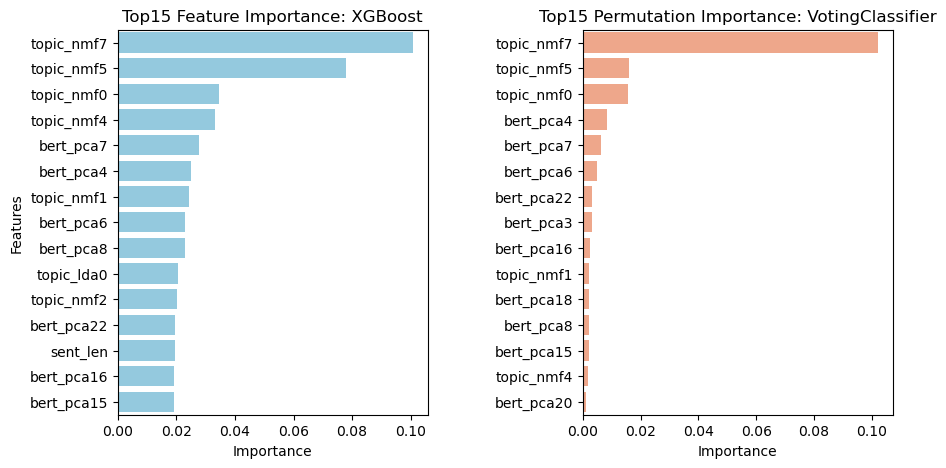

In [ ]:
# Plot the top 15 most important features from XGBoost and VotingClassifier
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
plt.subplots_adjust(wspace = 0.5)
ax1 = sns.barplot(data = xgb_feat_imp.head(15), x = 'Importance', y = 'Features', 
                  color = 'skyblue', ax = ax1)
ax1.set_title('Top15 Feature Importance: XGBoost')

ax2 = sns.barplot(data = feat_imp.head(15), x = 'Importance', y = 'Features',
                  color = 'lightsalmon', ax = ax2)
ax2.set_ylabel('')
ax2.set_title('Top15 Permutation Importance: VotingClassifier');

#### Supervised Model

In [43]:
# Random forest on the tfidf matrix
rf_tfidf = RandomForestClassifier(class_weight = 'balanced', random_state = 42).fit(tfidf_tuned_mx_tra, tra['author_encoded'])

# Get accuracy score
print('Train accuracy of rf_tfidf:', accuracy_score(tra['author_encoded'], rf_tfidf.predict(tfidf_tuned_mx_tra)))
print('Test Accuracy of rf_tfidf:', accuracy_score(val['author_encoded'], rf_tfidf.predict(tfidf_tuned_mx_val)))

Train accuracy of rf_tfidf: 0.9978259479506363
Test Accuracy of rf_tfidf: 0.6930946291560103


In [44]:
# XGBoost on the tfidf matrix
xgb_tfidf = XGBClassifier(objective = 'multi:softmax', num_class = 3, random_state = 42)
xgb_tfidf.fit(tfidf_tuned_mx_tra, tra['author_encoded'], sample_weight = sample_weights)

# Get accuracy score
print('Train accuracy of xgb_tfidf:', accuracy_score(tra['author_encoded'], xgb_tfidf.predict(tfidf_tuned_mx_tra)))
print('Test Accuracy of xgb_tfidf:', accuracy_score(val['author_encoded'], xgb_tfidf.predict(tfidf_tuned_mx_val)))

Train accuracy of xgb_tfidf: 0.8134791227060554
Test Accuracy of xgb_tfidf: 0.6941176470588235


The test accuracy of the supervised models trained on the TF-IDF matrix is higher than that of the unsupervised models, but lower than that of the hybrid models.

Since the focus of this project is exploring the use of unsupervised techniques for text classification, I will skip tuning the hyperparameters of the supervised models.

### Submit prediction on test set to Kaggle
  
Finally, I will train the model on the entire training set and generate predictions for Kaggle's test set. Before doing so, I need to extract the hybrid features from the entire training set and test set. So far, I have been training and tuning the model on a subset of the training set ('tra') and testing it on the validation set ('val').

In [210]:
# Create a tfidf vectorizer using the best_params --- for NMF model
tfidf_nmf = TfidfVectorizer(stop_words= 'english', min_df = 4, max_df = 0.8, max_features = 9000, ngram_range = (1, 2))

# Fit and transform the 'cleaned_text' from 'clean_train' and 'clean_test' into  tfidf-matrices
tfidf_nmf.fit(clean_train['cleaned_text'])
tfidf_nmf_train = tfidf_nmf.transform(clean_train['cleaned_text'])
tfidf_nmf_test = tfidf_nmf.transform(clean_test['cleaned_text'])

# Get w-matrix from NMF model 
nmf = NMF(n_components = 8, solver = 'mu', init = 'nndsvda', max_iter = 2000, beta_loss = 'kullback-leibler', random_state = 8)
nmf.fit(tfidf_nmf_train)
w_matrix_train = nmf.transform(tfidf_nmf_train)
w_matrix_test = nmf.transform(tfidf_nmf_test)

# Create a tfidf vectorizer using the best_params --- for LDA model
tfidf_lda = TfidfVectorizer(stop_words= 'english', max_df = 0.8, min_df = 6, max_features = 6000, ngram_range = (1, 2))

# Fit and transform the 'cleaned_text' from 'clean_train' and 'clean_test' into  tfidf-matrices
tfidf_lda.fit(clean_train['cleaned_text'])
tfidf_lda_train = tfidf_lda.transform(clean_train['cleaned_text'])
tfidf_lda_test = tfidf_lda.transform(clean_test['cleaned_text'])

# Get doc-topic matrix from LDA model
lda = LatentDirichletAllocation(n_components = 5, learning_decay = 0.8, doc_topic_prior = 0.1, random_state = 8)
lda.fit(tfidf_lda_train)
lda_topics_train = lda.transform(tfidf_lda_train)
lda_topics_test = lda.transform(tfidf_lda_test)


In [221]:
# Get dimensionality reduced BERT Embedding
pooled_output_train = pd.concat([pooled_output_tra, pooled_output_val])
pooled_output_test.columns = pooled_output_train.columns
pca = PCA(n_components= 0.95).fit(pooled_output_train)
bert_pca_train = pca.transform(pooled_output_train)
bert_pca_test = pca.transform(pooled_output_test)

In [ ]:
# Concatenate doc-topic matrices and the dimensional reduced BERT Embedding
hybrid_feature_train = np.concatenate((w_matrix_train, lda_topics_train, bert_pca_train), axis = 1)
hybrid_feature_test = np.concatenate((w_matrix_test, lda_topics_test, bert_pca_test), axis = 1)

# Convert hybrid_feature_train and hybrid_feature_test into a data frame
hybrid_feature_train = pd.DataFrame(hybrid_feature_train, columns = [f'topic_nmf{i}' for i in range(8)] + [f'topic_lda{i}' for i in range(5)] + [f'bert_pca{i}' for i in range(30)])
hybrid_feature_test = pd.DataFrame(hybrid_feature_test, columns = [f'topic_nmf{i}' for i in range(8)] + [f'topic_lda{i}' for i in range(5)] + [f'bert_pca{i}' for i in range(30)])

# Concatenate 'dt_train' and 'dt_test with linguistic features
hybrid_feature_train = pd.concat([hybrid_feature_train, clean_train[['gunning_fog', 'sent_len', 'word_len', 'noun_freq', 'verb_freq', 
                            'adj_freq', 'adv_freq', 'funct_word', 'type_token']]], axis = 1)
hybrid_feature_test = pd.concat([hybrid_feature_test, clean_test[['gunning_fog', 'sent_len', 'word_len', 'noun_freq', 'verb_freq', 
                            'adj_freq', 'adv_freq', 'funct_word', 'type_token']]], axis = 1)

In [244]:
# Train the VotingClassifier on 'hybrid_feature_train'
sample_weights_train = compute_sample_weight(class_weight = 'balanced', y = clean_train['author_encoded'])
vc.fit(hybrid_feature_train, clean_train['author_encoded'], sample_weight = sample_weights_train)

pred_proba_test = vc.predict_proba(hybrid_feature_test)

pred_proba_test = pd.DataFrame(pred_proba_test, columns = ['EAP', 'MWS', 'HPL'])
pred_proba_test = pd.concat([clean_test[['id']], pred_proba_test], axis = 1)
pred_proba_test = pred_proba_test[['id', 'EAP', 'HPL', 'MWS']]
pred_proba_test.head()

,id,EAP,HPL,MWS
0,id02310,0.042103,0.065524,0.892373
1,id24541,0.291389,0.671225,0.037386
2,id00134,0.102710,0.884563,0.012727
3,id27757,0.083545,0.883755,0.032700
4,id04081,0.821852,0.062855,0.115293


In [247]:
sample_submission.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [248]:
# Save the result
pred_proba_test.to_csv('pred_proba_test.csv', index = False)

I submitted the result to Kaggle and got a log-loss of 0.6553.